# XGBoost Regression을 사용한 택시 수요 예측  
  
1. yesterday,today,tomorrow 변수 -> 하나의 변수(ytt)로 통합
2. hour(시간대), ytt(어제,오늘,내일 휴일 여부 ex) 전부 휴일 : 111) 변수 카테고리형 타입 변환
3. target(count) 종속변수 LOG변환 X, LOG변환 O 두가지 경우의 RMSE값 비교 확인
4. 원본 데이터의 2018-10-09 한글날 Update X, Update O 두가지 경우 해당일 예측 비교 확인 
5. GridSearchCV 를 통한 랜덤포레스트의 하이퍼 파라미터 튜닝  
5. K-Fold 교차검증
6. TimeSeriesSplit 시계열 교차검증
7. 최종예측 & 성능평가

## 필요한 모듈 import 

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.utils import shuffle
import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager as fm
from matplotlib import rc

# 시각화 그래프 '-' & 한글 깨짐 현상 처리
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc

mpl.rcParams['axes.unicode_minus'] = False
font_name = fm.FontProperties(fname='c:\\windows\\fonts\\malgun.ttf').get_name()
rc('font', family=font_name)

# 경고메시지 숨김
import warnings
warnings.filterwarnings(action='ignore')
# 경고메시지 다시 보이게
#warnings.filterwarnings(action='default')

## 데이터 준비

### 데이터 로드

In [2]:
# 유동인구 없는 데이터
taxi = pd.read_csv("data/T-Money/seolleung_dataset.csv", parse_dates=["o_time"])
taxi['hour'] = taxi['o_time'].dt.hour
taxi['ytt'] = taxi[['yesterday', 'today', 'tomorrow']].apply(lambda x: ''.join(x.astype(str)), axis=1)
taxi = taxi[['o_time', 'hour', 'ytt', 'temp', 'windspeed', 'humidity', 'cloud', 'precipitation', 
             'snowcover', 'visibility', 'user', 'count']]
taxi.head()

,o_time,hour,ytt,temp,windspeed,humidity,cloud,precipitation,snowcover,visibility,user,count
0,2018-10-01 00:00:00,0,100,14.1,2.6,55,0.0,0.0,0.0,2000,1.0,52
1,2018-10-01 01:00:00,1,100,13.9,2.0,57,2.0,0.0,0.0,2000,1.0,17
2,2018-10-01 02:00:00,2,100,13.9,2.4,56,4.0,0.0,0.0,2000,1.0,10
3,2018-10-01 03:00:00,3,100,13.6,1.6,56,8.0,0.0,0.0,2000,1.0,13
4,2018-10-01 04:00:00,4,100,13.7,1.9,56,10.0,0.0,0.0,2000,1.0,12


In [3]:
# 유동인구 컬럼 추가한 데이터
taxi_add_pop = pd.read_csv("data/T-Money/seolleung_dataset_add_pop.csv", parse_dates=["o_time"])
taxi_add_pop['hour'] = taxi_add_pop['o_time'].dt.hour
taxi_add_pop['ytt'] = taxi_add_pop[['yesterday', 'today', 'tomorrow']].apply(lambda x: ''.join(x.astype(str)), axis=1)
taxi_add_pop = taxi_add_pop[['o_time', 'hour', 'ytt', 'temp', 'windspeed', 'humidity', 'cloud', 'precipitation', 
                             'snowcover', 'visibility', 'user', 'pop', 'count']]
taxi_add_pop.head()

,o_time,hour,ytt,temp,windspeed,humidity,cloud,precipitation,snowcover,visibility,user,pop,count
0,2018-10-01 00:00:00,0,100,14.1,2.6,55,0.0,0.0,0.0,2000,1.0,299.31,52
1,2018-10-01 01:00:00,1,100,13.9,2.0,57,2.0,0.0,0.0,2000,1.0,196.59,17
2,2018-10-01 02:00:00,2,100,13.9,2.4,56,4.0,0.0,0.0,2000,1.0,173.37,10
3,2018-10-01 03:00:00,3,100,13.6,1.6,56,8.0,0.0,0.0,2000,1.0,131.52,13
4,2018-10-01 04:00:00,4,100,13.7,1.9,56,10.0,0.0,0.0,2000,1.0,254.17,12


### 2018-10-09 화 (한글날) ytt 업데이트 데이터 별도 생성

In [4]:
# 유동인구 없는 데이터
taxi_ytt_up = taxi.set_index('o_time',inplace=False)
taxi_ytt_up['2018-10-08'].ytt = '101'
taxi_ytt_up['2018-10-09'].ytt = '010'
taxi_ytt_up['2018-10-10'].ytt = '100'
taxi_ytt_up['2018-10-08':'2018-10-10']

,hour,ytt,temp,windspeed,humidity,cloud,precipitation,snowcover,visibility,user,count
o_time,,,,,,,,,,,
2018-10-08 00:00:00,0,101,12.3,0.8,44,0.0,0.0,0.0,2000,1.0,56
2018-10-08 01:00:00,1,101,11.7,1.1,52,1.0,0.0,0.0,2000,1.0,31
2018-10-08 02:00:00,2,101,11.1,1.4,56,3.0,0.0,0.0,2000,1.0,20
2018-10-08 03:00:00,3,101,10.8,0.5,59,1.0,0.0,0.0,2000,1.0,14
2018-10-08 04:00:00,4,101,10.4,0.6,61,1.0,0.0,0.0,2000,1.0,12
2018-10-08 05:00:00,5,101,9.8,0.5,63,1.0,0.0,0.0,2000,1.0,17
2018-10-08 06:00:00,6,101,9.5,0.9,68,1.0,0.0,0.0,2000,1.0,11
2018-10-08 07:00:00,7,101,9.2,1.0,72,3.0,0.0,0.0,2000,1.0,29
2018-10-08 08:00:00,8,101,9.9,1.2,66,7.0,0.0,0.0,2000,1.0,139


In [5]:
# reset_index
taxi_ytt_up.reset_index(inplace=True)
taxi_ytt_up.head()

,o_time,hour,ytt,temp,windspeed,humidity,cloud,precipitation,snowcover,visibility,user,count
0,2018-10-01 00:00:00,0,100,14.1,2.6,55,0.0,0.0,0.0,2000,1.0,52
1,2018-10-01 01:00:00,1,100,13.9,2.0,57,2.0,0.0,0.0,2000,1.0,17
2,2018-10-01 02:00:00,2,100,13.9,2.4,56,4.0,0.0,0.0,2000,1.0,10
3,2018-10-01 03:00:00,3,100,13.6,1.6,56,8.0,0.0,0.0,2000,1.0,13
4,2018-10-01 04:00:00,4,100,13.7,1.9,56,10.0,0.0,0.0,2000,1.0,12


In [6]:
# 유동인구 추가된 데이터
taxipop_ytt_up = taxi_add_pop.set_index('o_time',inplace=False)
taxipop_ytt_up['2018-10-08'].ytt = '101'
taxipop_ytt_up['2018-10-09'].ytt = '010'
taxipop_ytt_up['2018-10-10'].ytt = '100'
taxipop_ytt_up['2018-10-08':'2018-10-10']

,hour,ytt,temp,windspeed,humidity,cloud,precipitation,snowcover,visibility,user,pop,count
o_time,,,,,,,,,,,,
2018-10-08 00:00:00,0,101,12.3,0.8,44,0.0,0.0,0.0,2000,1.0,328.36,56
2018-10-08 01:00:00,1,101,11.7,1.1,52,1.0,0.0,0.0,2000,1.0,244.22,31
2018-10-08 02:00:00,2,101,11.1,1.4,56,3.0,0.0,0.0,2000,1.0,170.25,20
2018-10-08 03:00:00,3,101,10.8,0.5,59,1.0,0.0,0.0,2000,1.0,161.00,14
2018-10-08 04:00:00,4,101,10.4,0.6,61,1.0,0.0,0.0,2000,1.0,242.38,12
2018-10-08 05:00:00,5,101,9.8,0.5,63,1.0,0.0,0.0,2000,1.0,1474.69,17
2018-10-08 06:00:00,6,101,9.5,0.9,68,1.0,0.0,0.0,2000,1.0,4028.41,11
2018-10-08 07:00:00,7,101,9.2,1.0,72,3.0,0.0,0.0,2000,1.0,12059.28,29
2018-10-08 08:00:00,8,101,9.9,1.2,66,7.0,0.0,0.0,2000,1.0,13639.86,139


In [7]:
# reset_index
taxipop_ytt_up.reset_index(inplace=True)
taxipop_ytt_up.head()

,o_time,hour,ytt,temp,windspeed,humidity,cloud,precipitation,snowcover,visibility,user,pop,count
0,2018-10-01 00:00:00,0,100,14.1,2.6,55,0.0,0.0,0.0,2000,1.0,299.31,52
1,2018-10-01 01:00:00,1,100,13.9,2.0,57,2.0,0.0,0.0,2000,1.0,196.59,17
2,2018-10-01 02:00:00,2,100,13.9,2.4,56,4.0,0.0,0.0,2000,1.0,173.37,10
3,2018-10-01 03:00:00,3,100,13.6,1.6,56,8.0,0.0,0.0,2000,1.0,131.52,13
4,2018-10-01 04:00:00,4,100,13.7,1.9,56,10.0,0.0,0.0,2000,1.0,254.17,12


### 명목형 변수 (hour, ytt) type 카테고리형 변경

In [8]:
taxi['hour'] = taxi['hour'].astype('category')
taxi['ytt'] = taxi['ytt'].astype('category')

taxi_add_pop['hour'] = taxi_add_pop['hour'].astype('category')
taxi_add_pop['ytt'] = taxi_add_pop['ytt'].astype('category')

taxi_ytt_up['hour'] = taxi_ytt_up['hour'].astype('category')
taxi_ytt_up['ytt'] = taxi_ytt_up['ytt'].astype('category')

taxipop_ytt_up['hour'] = taxipop_ytt_up['hour'].astype('category')
taxipop_ytt_up['ytt'] = taxipop_ytt_up['ytt'].astype('category')

# 데이터셋 한개만 확인
print(taxipop_ytt_up.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 13 columns):
o_time           4368 non-null datetime64[ns]
hour             4368 non-null category
ytt              4368 non-null category
temp             4368 non-null float64
windspeed        4368 non-null float64
humidity         4368 non-null int64
cloud            4368 non-null float64
precipitation    4368 non-null float64
snowcover        4368 non-null float64
visibility       4368 non-null int64
user             4368 non-null float64
pop              4368 non-null float64
count            4368 non-null int64
dtypes: category(2), datetime64[ns](1), float64(7), int64(3)
memory usage: 385.2 KB
None


### o_time 컬럼 제거

In [9]:
# 유동인구 x 한글날 ytt 업데이트 x
data1 = taxi.drop(['o_time'],axis=1, inplace=False)

# 유동인구 o 한글날 ytt 업데이트 x
data2 = taxi_add_pop.drop(['o_time'],axis=1, inplace=False)

# 유동인구 x 한글날 ytt 업데이트 o
data3 = taxi_ytt_up.drop(['o_time'],axis=1, inplace=False)

# 유동인구 o 한글날 ytt 업데이트 o
data4 = taxipop_ytt_up.drop(['o_time'],axis=1, inplace=False)

### XGBoost는 범주형변수 (object,category)를 입력받을 수 없기 때문에 hour,ytt 원핫인코딩

In [10]:
data1 = pd.get_dummies(data1, columns=['hour','ytt'])
data2 = pd.get_dummies(data2, columns=['hour','ytt'])
data3 = pd.get_dummies(data3, columns=['hour','ytt'])
data4 = pd.get_dummies(data4, columns=['hour','ytt'])

## 훈련, 검증 데이터셋 분리

### feature, target 분리

In [11]:
# 유동인구 x 한글날 ytt 업데이트 x
y_target1 = data1['count']
X_data1 = data1.drop(['count'], axis=1, inplace=False)

# 유동인구 o 한글날 ytt 업데이트 x
y_target2 = data2['count']
X_data2 = data2.drop(['count'], axis=1, inplace=False)

# 유동인구 x 한글날 ytt 업데이트 o
y_target3 = data3['count']
X_data3 = data3.drop(['count'], axis=1, inplace=False)

# 유동인구 o 한글날 ytt 업데이트 o
y_target4 = data4['count']
X_data4 = data4.drop(['count'], axis=1, inplace=False)

### 훈련, 검증 데이터셋 분리

-- 2019-02-05 설 마지막날의 row 확인

In [29]:
taxi[taxi['o_time']=='2019-02-05 23:00:00']

,o_time,hour,ytt,temp,windspeed,humidity,cloud,precipitation,snowcover,visibility,user,count
3071,2019-02-05 23:00:00,23,111,2.7,1.4,41,6.0,0.0,0.0,939,1.0,26


-- 설 마지막날 다음날 까지 훈련데이터, 그 이후 검증데이터

In [638]:
# 유동인구 x 한글날 ytt 업데이트 x
X_train1, X_test1, y_train1, y_test1 = X_data1.iloc[0:3096,0:], X_data1.iloc[3096:,0:], y_target1[0:3096], y_target1[3096:]

# 유동인구 o 한글날 ytt 업데이트 x
X_train2, X_test2, y_train2, y_test2 = X_data2.iloc[0:3096,0:], X_data2.iloc[3096:,0:], y_target2[0:3096], y_target2[3096:]

# 유동인구 x 한글날 ytt 업데이트 o
X_train3, X_test3, y_train3, y_test3 = X_data3.iloc[0:3096,0:], X_data3.iloc[3096:,0:], y_target3[0:3096], y_target3[3096:]

# 유동인구 o 한글날 ytt 업데이트 o
X_train4, X_test4, y_train4, y_test4 = X_data4.iloc[0:3096,0:], X_data4.iloc[3096:,0:], y_target4[0:3096], y_target4[3096:]

In [17]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_data3, y_target3, test_size=0.3, random_state=127)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_data4, y_target4, test_size=0.3, random_state=127)

-- 나뉜 훈련,검증 데이터셋 shuffle (일반 교차검증 시 사용)

In [74]:
# 유동인구 x 한글날 ytt 업데이트 x
X_train1, y_train1 = shuffle(X_train1, y_train1)
X_test1, y_test1 = shuffle(X_test1, y_test1)

# 유동인구 o 한글날 ytt 업데이트 x
X_train2, y_train2 = shuffle(X_train2, y_train2)
X_test2, y_test2 = shuffle(X_test2, y_test2)

# 유동인구 x 한글날 ytt 업데이트 o
X_train3, y_train3 = shuffle(X_train3, y_train3)
X_test3, y_test3 = shuffle(X_test3, y_test3)

# 유동인구 o 한글날 ytt 업데이트 o
X_train4, y_train4 = shuffle(X_train4, y_train4)
X_test4, y_test4 = shuffle(X_test4, y_test4)

## 회귀모델 성능평가 함수 생성

In [13]:
def rmsle(y,pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

def evaluate_regr(y,pred):
    mae_val = mean_absolute_error(y,pred)
    mse_val = mean_squared_error(y,pred)
    rmse_val = rmse(y,pred)
    rmsle_val = rmsle(y,pred)
    print('MAE : {0:.3f}, MSE : {1:.3F}, RMSE : {2:.3F}, RMSLE : {3:.3F}'.format(mae_val,mse_val,rmse_val,rmsle_val))

## XGBoost 기본모델 생성 및 성능평가 (유동인구 컬럼 X 데이터)  
- 유동인구 x, 한글날 ytt 업데이트 x : X_train1,y_train1,X_test1,y_test1  
- 유동인구 x, 한글날 ytt 업데이트 o : X_train3,y_train3,X_test3,y_test3  

### 한글날 ytt 업데이트 하지않은 데이터셋

__target log변환 x__

In [80]:
xgb_model = XGBRegressor()

xgb_model.fit(X_train1, y_train1)
pred = xgb_model.predict(X_test1)

evaluate_regr(y_test1,pred)

[16:33:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE : 16.069, MSE : 456.536, RMSE : 21.367, RMSLE : 0.375


__target log변환 o__

In [83]:
xgb_model1 = XGBRegressor()

y_train1_log = np.log1p(y_train1)
xgb_model1.fit(X_train1, y_train1_log)

pred = xgb_model1.predict(X_test1)
pred_log = np.exp(pred)

evaluate_regr(y_test1,pred_log)

[16:37:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE : 16.757, MSE : 536.703, RMSE : 23.167, RMSLE : 0.323


__model 상세__

In [84]:
xgb_model1

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

#### feature 중요도 시각화

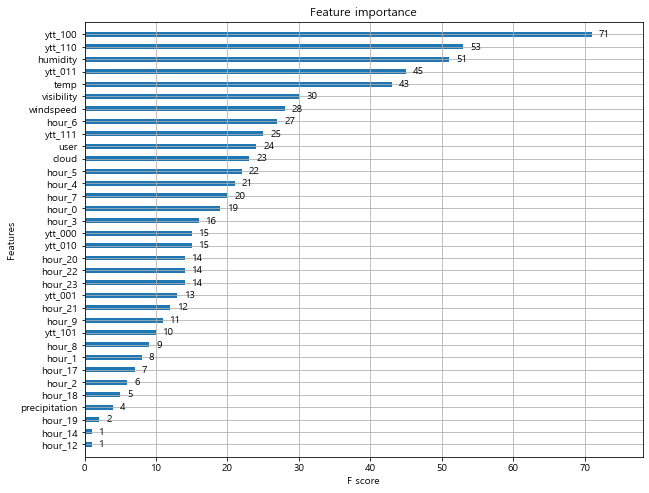

In [89]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
xgb.plot_importance(xgb_model1, ax=ax, max_num_features=50, height=0.4)

### 한글날 ytt 업데이트 한 데이터셋

__target log변환 x__

In [20]:
xgb_model1 = XGBRegressor()

xgb_model1.fit(X_train1, y_train1)
pred = xgb_model1.predict(X_test1)

evaluate_regr(y_test1,pred)

[12:53:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE : 15.991, MSE : 440.763, RMSE : 20.994, RMSLE : 0.347


In [24]:
eva = taxi.reset_index(inplace=False)

xgb_model1.fit(X_train1,y_train1)
pred = xgb_model1.predict(total_data2)

evaluate_regr(eva['count'],pred)

[12:55:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE : 15.605, MSE : 421.493, RMSE : 20.530, RMSLE : 0.366


__target log변환 o__

In [26]:
xgb_model1 = XGBRegressor()

y_train1_log = np.log1p(y_train1)
xgb_model1.fit(X_train1, y_train1_log)

pred = xgb_model1.predict(X_test1)
pred_log = np.exp(pred)

evaluate_regr(y_test1,pred_log)

[12:56:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE : 16.683, MSE : 544.278, RMSE : 23.330, RMSLE : 0.304


__model 상세__

In [92]:
xgb_model1

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

#### feature 중요도 시각화

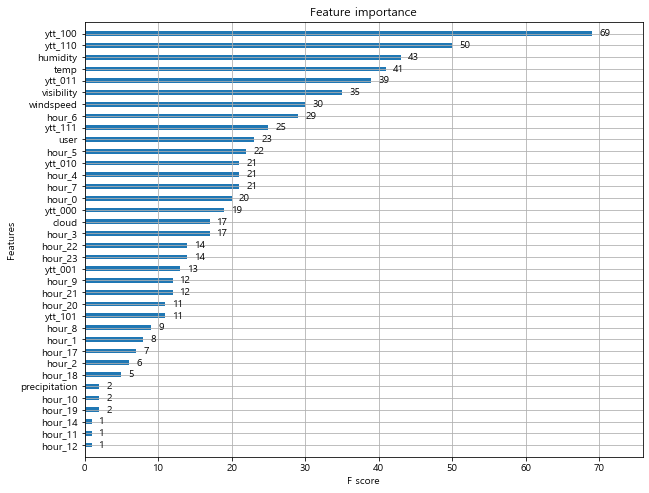

In [93]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
xgb.plot_importance(xgb_model1, ax=ax, max_num_features=50, height=0.4)

## GridSearchCV 를 이용한 파라미터 튜닝 (유동인구 컬럼 X 데이터)  
- 한글날 ytt 업데이트 하지않은 데이터셋 테스트.
- 한글날 ytt 업데이트 한 데이터셋 테스트.

### 파라미터 리스트 작성 및 GridSearchCV 사용 튜닝

In [321]:
xgb_rg = XGBRegressor()
params = {'max_depth':[5,7,10],
          'min_child_weight':[1,4,7],
          'gamma':[1,3,5],
          'nthread':[2,4,6],
          'n_estimators':[50,100,200],
          'learning_rate': [0.1]}

gscv = GridSearchCV(xgb_rg, params, cv=5, scoring='neg_mean_squared_error')
gscv.fit(X_train1,y_train1)

[18:17:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:17:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:17:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:17:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:17:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:17:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:17:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:17:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:17:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[18:17:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:17:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:17:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:17:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:17:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:17:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:17:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:17:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:17:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[18:17:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:17:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:17:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:17:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:17:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:17:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:17:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:17:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:17:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[18:18:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:18:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:18:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:18:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:18:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:18:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:18:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:18:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:18:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[18:18:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:18:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:18:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:18:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:18:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:18:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:18:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:18:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:18:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[18:19:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:19:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:19:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:19:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:19:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:19:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:19:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:19:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:19:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[18:19:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:19:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:19:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:19:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:19:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:19:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:19:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:19:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:19:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[18:20:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:20:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:20:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:20:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:20:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:20:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:20:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:20:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:20:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[18:20:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:20:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:20:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:20:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:20:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:20:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:20:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:20:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:20:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[18:20:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:20:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:20:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:20:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:20:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:20:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:20:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:20:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:20:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[18:21:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:21:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:21:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:21:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:21:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:21:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:21:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:21:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:21:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[18:21:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:21:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:21:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:21:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:21:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:21:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:21:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:21:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:21:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[18:22:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:22:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:22:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:22:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:22:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:22:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:22:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:22:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:22:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[18:22:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:22:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:22:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:22:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:22:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:22:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:22:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:22:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:22:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[18:23:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:23:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:23:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:23:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:23:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:23:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:23:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:23:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:23:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[18:24:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:24:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:24:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:24:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:24:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:24:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:24:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:24:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:24:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[18:25:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:25:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:25:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:25:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:25:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:25:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:25:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [5, 7, 10], 'min_child_weight': [1, 4, 7], 'gamma': [1, 3, 5], 'nthread': [2, 4, 6], 'n_estimators': [50, 100, 200], 'learning_rate': [0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [322]:
print('final params : ', gscv.best_params_)
print('best RMSE : ', np.sqrt(np.abs(gscv.best_score_)))

final params :  {'gamma': 3, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 7, 'n_estimators': 200, 'nthread': 2}
best RMSE :  15.505957620070074


__직접 학습__

In [594]:
xgb_rg = XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=10, gamma=10, nthread=10, subsample=0.8, min_child_weight=3)
                     #,colsample_bylevel=1, colsample_bytree=1)

evals = [(X_test1,y_test1)]

xgb_rg.fit(X_train1, y_train1, early_stopping_rounds=200, eval_set = evals,eval_metric='rmse')
pred = xgb_rg.predict(X_test1)

[10:04:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:78.6994
Will train until validation_0-rmse hasn't improved in 200 rounds.
[1]	validation_0-rmse:71.7701
[2]	validation_0-rmse:65.474
[3]	validation_0-rmse:59.7299
[4]	validation_0-rmse:54.81
[5]	validation_0-rmse:50.192
[6]	validation_0-rmse:45.978
[7]	validation_0-rmse:42.2776
[8]	validation_0-rmse:39.2044
[9]	validation_0-rmse:36.3117
[10]	validation_0-rmse:33.6991
[11]	validation_0-rmse:31.1424
[12]	validation_0-rmse:29.115
[13]	validation_0-rmse:27.3416
[14]	validation_0-rmse:25.5972
[15]	validation_0-rmse:24.1994
[16]	validation_0-rmse:22.8835
[17]	validation_0-rmse:21.8644
[18]	validation_0-rmse:21.0165
[19]	validation_0-rmse:20.2886
[20]	validation_0-rmse:19.6845
[21]	validation_0-rmse:19.1292
[22]	validation_0-rmse:18.6982
[23]	validation_0-rmse:18.3011
[24]	validation_0-rmse:18
[25]	validation_0-rmse:17.6921
[26]	validation_0-rmse:17.4426
[2

[255]	validation_0-rmse:16.2435
[256]	validation_0-rmse:16.2453
[257]	validation_0-rmse:16.2472
[258]	validation_0-rmse:16.2515
[259]	validation_0-rmse:16.2514
[260]	validation_0-rmse:16.251
[261]	validation_0-rmse:16.2513
[262]	validation_0-rmse:16.2503
[263]	validation_0-rmse:16.2504
[264]	validation_0-rmse:16.2498
[265]	validation_0-rmse:16.2531
[266]	validation_0-rmse:16.2523
[267]	validation_0-rmse:16.2508
[268]	validation_0-rmse:16.2513
[269]	validation_0-rmse:16.2526
[270]	validation_0-rmse:16.255
[271]	validation_0-rmse:16.2522
[272]	validation_0-rmse:16.2542
[273]	validation_0-rmse:16.2545
[274]	validation_0-rmse:16.256
Stopping. Best iteration:
[74]	validation_0-rmse:15.7364



In [363]:
evaluate_regr(y_test1,pred)

MAE : 11.222, MSE : 245.569, RMSE : 15.671, RMSLE : 0.245


### 튜닝된 최적의 파라미터로 모델 생성 및 평가

In [373]:
final_xgb_model = gscv.best_estimator_

final_xgb_model.fit(X_train1,y_train1)
pred = final_xgb_model.predict(X_test1)

evaluate_regr(y_test1,pred)

[18:44:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE : 11.879, MSE : 269.369, RMSE : 16.412, RMSLE : 0.271


### feature 중요도 시각화

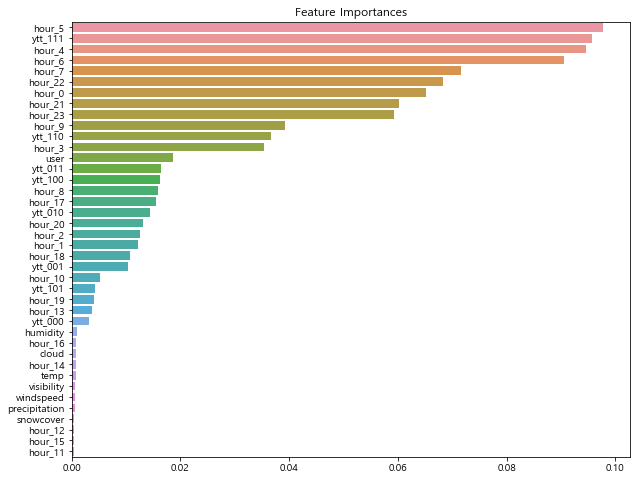

In [376]:
ftr_importances_values = final_xgb_model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train1.columns).sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title('Feature Importances')
sns.barplot(x=ftr_importances, y=ftr_importances.index)
plt.show()

### 튜닝된 모델로 전체데이터 예측

In [370]:
total_data1 = data1.drop('count',axis=1,inplace=False)
total_data1

,temp,windspeed,humidity,cloud,precipitation,snowcover,visibility,user,hour_0,hour_1,...,hour_22,hour_23,ytt_000,ytt_001,ytt_010,ytt_011,ytt_100,ytt_101,ytt_110,ytt_111
0,14.1,2.6,55,0.0,0.0,0.0,2000,1.0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,13.9,2.0,57,2.0,0.0,0.0,2000,1.0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,13.9,2.4,56,4.0,0.0,0.0,2000,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,13.6,1.6,56,8.0,0.0,0.0,2000,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,13.7,1.9,56,10.0,0.0,0.0,2000,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,13.7,1.8,57,8.0,0.0,0.0,1999,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
6,13.3,2.3,56,7.0,0.0,0.0,2000,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
7,13.1,2.1,58,3.0,0.0,0.0,1997,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
8,13.7,2.4,54,7.0,0.0,0.0,1960,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
9,14.9,3.4,50,1.0,0.0,0.0,1989,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [389]:
a = final_xgb_model.predict(total_data1)
taxi['pred1'] = a

In [390]:
evaluate_regr(taxi['count'],a)

MAE : 6.016, MSE : 96.385, RMSE : 9.818, RMSLE : 0.168


#### 전체기간

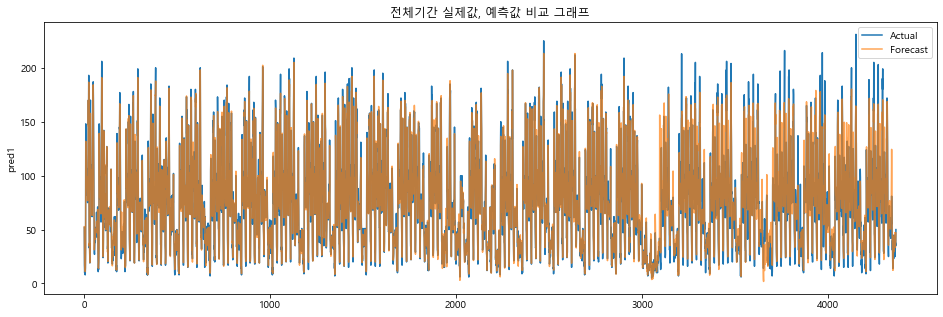

In [377]:
plt.figure(figsize=(16,5))
plt.title('전체기간 실제값, 예측값 비교 그래프')
sns.lineplot(x=taxi.index,y='count',data=taxi)
sns.lineplot(x=taxi.index,y='pred1',data=taxi,alpha=0.7)
plt.legend(['Actual','Forecast'])
plt.show()

#### 한달

In [393]:
taxi.set_index('o_time',inplace=True)

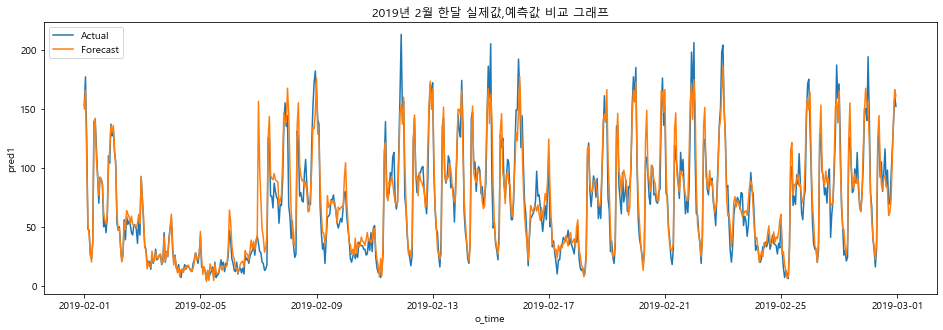

In [394]:
plt.figure(figsize=(16,5))
plt.title('2019년 2월 한달 실제값,예측값 비교 그래프')
sns.lineplot(x=taxi['2019-02'].index,y='count',data=taxi['2019-02'])
sns.lineplot(x=taxi['2019-02'].index,y='pred1',data=taxi['2019-02'])
plt.legend(['Actual','Forecast'])
plt.show()

#### 일주일

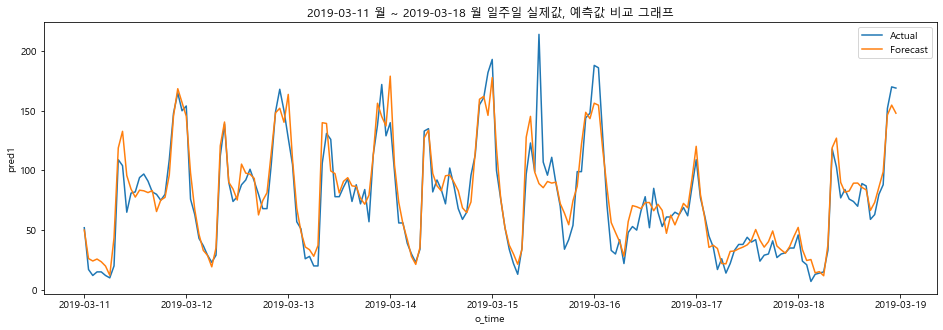

In [395]:
plt.figure(figsize=(16,5))
plt.title('2019-03-11 월 ~ 2019-03-18 월 일주일 실제값, 예측값 비교 그래프')
sns.lineplot(x=taxi['2019-03-11':'2019-03-18'].index,y='count',data=taxi['2019-03-11':'2019-03-18'])
sns.lineplot(x=taxi['2019-03-11':'2019-03-18'].index,y='pred1',data=taxi['2019-03-11':'2019-03-18'])
plt.legend(['Actual','Forecast'])
plt.show()

#### 한글날 ytt 업데이트 x

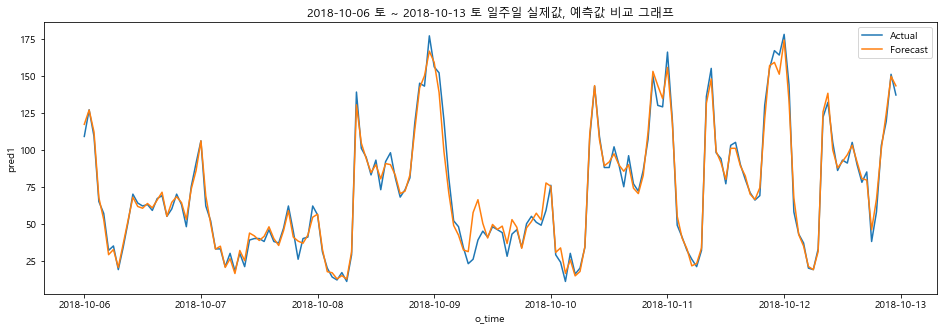

In [398]:
plt.figure(figsize=(16,5))
plt.title('2018-10-06 토 ~ 2018-10-13 토 일주일 실제값, 예측값 비교 그래프')
sns.lineplot(x=taxi['2018-10-06':'2018-10-12'].index,y='count',data=taxi['2018-10-06':'2018-10-12'])
sns.lineplot(x=taxi['2018-10-06':'2018-10-12'].index,y='pred1',data=taxi['2018-10-06':'2018-10-12'])
plt.legend(['Actual','Forecast'])
plt.show()

#### 한글날 ytt 업데이트 o

__한글날 ytt 업데이트 된 데이터셋으로 훈련 후 다시 예측__

__한글날 ytt 업데이트 된 데이터로 훈련데이터셋 생성__

In [23]:
total_data2 = data3.drop('count',axis=1,inplace=False)
total_data2.head()

,temp,windspeed,humidity,cloud,precipitation,snowcover,visibility,user,hour_0,hour_1,...,hour_22,hour_23,ytt_000,ytt_001,ytt_010,ytt_011,ytt_100,ytt_101,ytt_110,ytt_111
0,14.1,2.6,55,0.0,0.0,0.0,2000,1.0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,13.9,2.0,57,2.0,0.0,0.0,2000,1.0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,13.9,2.4,56,4.0,0.0,0.0,2000,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,13.6,1.6,56,8.0,0.0,0.0,2000,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,13.7,1.9,56,10.0,0.0,0.0,2000,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0


__모델을 생성 & 예측하고 예측값 컬럼 추가__

In [401]:
final_xgb_model.fit(X_train3,y_train3)

b = final_xgb_model.predict(total_data2)
taxi['pred2'] = b

[19:01:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


__RMSE 확인__

In [402]:
evaluate_regr(taxi['count'],b)

MAE : 5.927, MSE : 94.591, RMSE : 9.726, RMSLE : 0.167


__시각화__

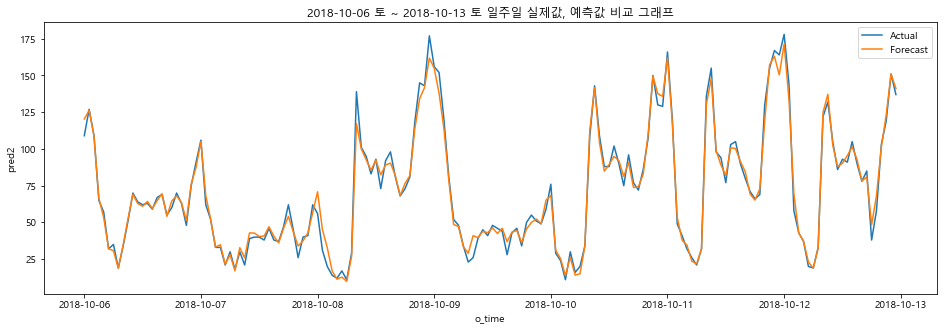

In [403]:
plt.figure(figsize=(16,5))
plt.title('2018-10-06 토 ~ 2018-10-13 토 일주일 실제값, 예측값 비교 그래프')
sns.lineplot(x=taxi['2018-10-06':'2018-10-12'].index,y='count',data=taxi['2018-10-06':'2018-10-12'])
sns.lineplot(x=taxi['2018-10-06':'2018-10-12'].index,y='pred2',data=taxi['2018-10-06':'2018-10-12'])
plt.legend(['Actual','Forecast'])
plt.show()

## XGBoost 기본모델 생성 및 성능평가 (유동인구 컬럼 O 데이터)  
- 유동인구 o, 한글날 ytt 업데이트 x : X_train2,y_train2,X_test2,y_test2
- 유동인구 o, 한글날 ytt 업데이트 o : X_train4,y_train4,X_test4,y_test4  

### 한글날 ytt 업데이트 하지않은 데이터셋

__target log변환 x__

In [404]:
xgb_model = XGBRegressor()

xgb_model.fit(X_train2, y_train2)
pred = xgb_model.predict(X_test2)

evaluate_regr(y_test2,pred)

[19:10:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE : 14.123, MSE : 351.133, RMSE : 18.739, RMSLE : 0.310


__target log변환 o__

In [405]:
xgb_model = XGBRegressor()

y_train2_log = np.log1p(y_train2)
xgb_model.fit(X_train2, y_train2_log)

pred = xgb_model.predict(X_test2)
pred_log = np.exp(pred)

evaluate_regr(y_test2,pred_log)

[19:12:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE : 14.301, MSE : 407.607, RMSE : 20.189, RMSLE : 0.272


__model 상세__

In [406]:
xgb_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

#### feature 중요도 시각화

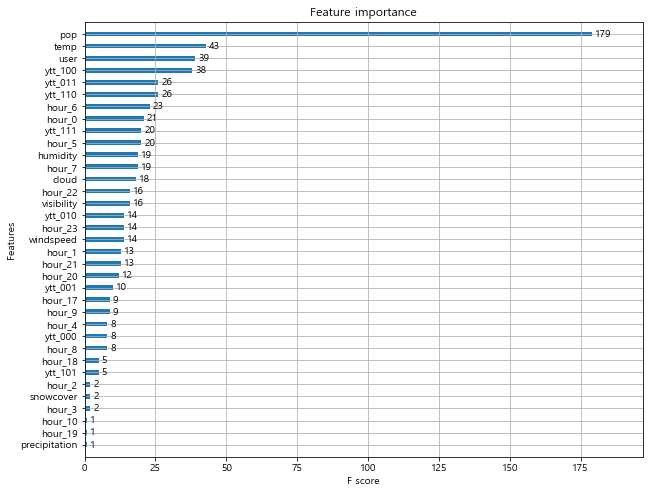

In [407]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
xgb.plot_importance(xgb_model, ax=ax, max_num_features=50, height=0.4)

### 한글날 ytt 업데이트 한 데이터셋

__target log변환 x__

In [953]:
xgb_model = XGBRegressor()

xgb_model.fit(X_train4, y_train4)
pred = xgb_model.predict(X_test4)

evaluate_regr(y_test4,pred)

[16:31:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE : 14.302, MSE : 356.915, RMSE : 18.892, RMSLE : 0.317


In [955]:
eva = taxi.reset_index(inplace=False)

xgb_model.fit(X_train4,y_train4)
pred = xgb_model.predict(total_data4)

evaluate_regr(eva['count'],pred)

[16:32:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE : 13.635, MSE : 322.045, RMSE : 17.946, RMSLE : 0.310


__target log변환 o__

In [409]:
xgb_model = XGBRegressor()

y_train4_log = np.log1p(y_train4)
xgb_model.fit(X_train4, y_train4_log)

pred = xgb_model.predict(X_test4)
pred_log = np.exp(pred)

evaluate_regr(y_test4,pred_log)

[19:14:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE : 13.976, MSE : 386.806, RMSE : 19.667, RMSLE : 0.272


__model 상세__

In [410]:
xgb_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

#### feature 중요도 시각화

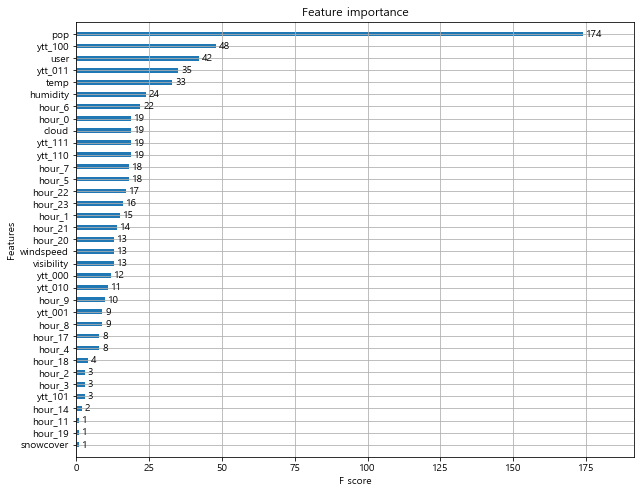

In [411]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
xgb.plot_importance(xgb_model, ax=ax, max_num_features=50, height=0.4)

## GridSearchCV 를 이용한 파라미터 튜닝 (유동인구 컬럼 O 데이터)  
- 한글날 ytt 업데이트 하지않은 데이터셋 테스트.
- 한글날 ytt 업데이트 한 데이터셋 테스트.

### 파라미터 리스트 작성 및 GridSearchCV 사용 튜닝

In [455]:
xgb_rg = XGBRegressor()
params = {'max_depth':[5,7,10],
          'min_child_weight':[1,4,7],
          'gamma':[1,3,5],
          'nthread':[2,4,6],
          'subsample':[0.3,0.7,1],
          'n_estimators':[100,200,500],
          'learning_rate': [0.1]}

gscv = GridSearchCV(xgb_rg, params, cv=5, scoring='neg_mean_squared_error')
gscv.fit(X_train2,y_train2)

[19:32:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:32:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:33:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:33:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:34:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:34:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:34:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:34:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:34:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:34:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:34:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:34:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:34:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:35:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:35:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:35:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:35:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:35:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:35:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:35:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:35:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:35:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:36:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:36:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:38:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:38:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:38:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:38:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:38:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:38:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:38:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:38:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:38:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:38:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:38:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:38:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:38:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:38:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:38:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:39:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:40:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:40:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:40:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:40:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:40:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:40:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:40:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:40:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:41:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:41:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:41:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:41:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:41:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:41:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:41:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:41:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:41:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:41:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:43:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:43:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:43:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:43:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:43:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:43:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:43:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:43:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:43:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:44:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:44:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:44:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:44:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:44:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:44:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:44:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:44:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:44:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:46:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:46:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:46:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:46:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:46:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:46:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:46:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:46:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:46:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:47:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:49:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:49:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:49:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:49:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:49:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:49:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:49:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:49:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:49:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:49:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:49:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:49:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:49:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:49:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:49:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:49:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:49:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:49:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:50:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:50:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:50:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:50:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:50:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:50:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:50:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:50:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:50:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:51:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:51:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:51:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:51:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:51:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:51:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:51:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:51:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:51:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:52:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:52:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:52:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:52:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:52:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:52:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:52:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:52:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:52:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:52:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:52:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:52:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:52:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:52:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:52:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:52:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:52:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:52:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:53:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:53:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:53:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:53:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:53:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:53:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:53:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:53:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:53:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:54:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:54:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:54:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:54:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:54:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:54:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:54:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:54:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:54:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:55:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:55:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:55:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:55:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:55:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:55:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:55:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:55:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:55:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:56:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:56:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:56:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:56:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:56:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:56:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:56:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:56:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:56:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:57:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:58:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:59:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:59:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:59:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:59:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:59:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:59:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:59:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:59:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:59:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[20:00:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:00:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:00:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:00:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:00:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:00:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:00:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:00:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:01:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[20:02:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:02:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:02:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:02:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:02:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:02:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:02:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:02:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:02:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[20:03:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:03:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:03:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:03:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:03:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:03:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:03:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:03:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:03:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[20:04:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:04:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:04:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:04:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:04:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:04:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:04:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:04:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:05:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[20:06:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:06:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:06:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:06:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:06:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:06:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:06:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:06:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:06:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[20:07:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:07:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:07:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:07:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:07:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:07:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:07:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:07:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:07:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[20:08:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:08:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:08:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:08:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:08:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:08:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:08:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:08:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:08:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[20:08:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:08:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:08:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:08:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:08:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:08:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:08:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:08:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:08:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[20:09:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:09:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:09:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:09:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:09:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:09:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:09:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:09:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:09:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[20:09:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:10:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:10:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:10:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:10:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:10:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:10:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:10:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:10:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[20:10:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:10:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:10:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:10:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:10:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:10:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:10:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:10:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:10:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[20:11:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:11:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:11:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:11:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:11:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:11:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:11:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:11:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:11:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[20:12:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[20:13:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[20:14:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:14:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:14:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:14:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:14:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:14:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:14:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:14:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:14:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[20:15:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:15:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:15:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:15:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:15:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:15:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:15:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:15:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:15:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[20:16:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:16:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:16:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:16:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:16:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:16:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:16:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:16:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:16:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[20:17:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:17:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:17:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[20:19:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:19:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:19:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:19:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:19:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:19:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:19:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:19:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:19:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[20:20:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:20:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:20:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:20:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:21:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:21:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:21:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:21:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:21:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[20:22:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:22:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:22:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:22:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:22:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:22:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:22:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:22:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:22:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[20:23:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:23:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:23:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:23:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:23:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:24:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:24:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:24:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:24:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [5, 7, 10], 'min_child_weight': [1, 4, 7], 'gamma': [1, 3, 5], 'nthread': [2, 4, 6], 'subsample': [0.3, 0.7, 1], 'n_estimators': [100, 200, 500], 'learning_rate': [0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [493]:
print('final params : ', gscv.best_params_)
print('best RMSE : ', np.sqrt(np.abs(gscv.best_score_)))

final params :  {'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 500, 'nthread': 2, 'subsample': 0.7}
best RMSE :  15.145106375285403


__직접 학습__

In [460]:
xgb_rg = XGBRegressor(n_estimators=600, learning_rate=0.1, max_depth=10, gamma=2, nthread=2, subsample=1, min_child_weight=2)
                     #,colsample_bylevel=1, colsample_bytree=1)

evals = [(X_test2,y_test2)]

xgb_rg.fit(X_train2, y_train2, early_stopping_rounds=200, eval_set = evals,eval_metric='rmse')
pred = xgb_rg.predict(X_test2)

[20:28:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:78.5167
Will train until validation_0-rmse hasn't improved in 200 rounds.
[1]	validation_0-rmse:71.4077
[2]	validation_0-rmse:65.0249
[3]	validation_0-rmse:59.2749
[4]	validation_0-rmse:54.204
[5]	validation_0-rmse:49.4764
[6]	validation_0-rmse:45.4852
[7]	validation_0-rmse:41.4962
[8]	validation_0-rmse:38.0144
[9]	validation_0-rmse:34.6919
[10]	validation_0-rmse:31.7673
[11]	validation_0-rmse:29.2285
[12]	validation_0-rmse:26.9396
[13]	validation_0-rmse:25.0124
[14]	validation_0-rmse:23.334
[15]	validation_0-rmse:21.9271
[16]	validation_0-rmse:20.7776
[17]	validation_0-rmse:19.87
[18]	validation_0-rmse:18.9817
[19]	validation_0-rmse:18.2379
[20]	validation_0-rmse:17.546
[21]	validation_0-rmse:16.9289
[22]	validation_0-rmse:16.5096
[23]	validation_0-rmse:16.1445
[24]	validation_0-rmse:15.8593
[25]	validation_0-rmse:15.6108
[26]	validation_0-rmse:15.4

### 튜닝된 최적의 파라미터로 모델 생성 및 평가

In [534]:
final_xgb_model = gscv.best_estimator_

final_xgb_model.fit(X_train2,y_train2)
pred = final_xgb_model.predict(X_test2)

evaluate_regr(y_test2,pred)

[21:27:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE : 11.804, MSE : 255.748, RMSE : 15.992, RMSLE : 0.252


In [535]:
final_xgb_model = gscv.best_estimator_

xgb_rg.fit(X_train2,y_train2)
pred = xgb_rg.predict(X_test2)

evaluate_regr(y_test2,pred)

[21:27:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE : 10.879, MSE : 219.088, RMSE : 14.802, RMSLE : 0.230


### feature 중요도 시각화

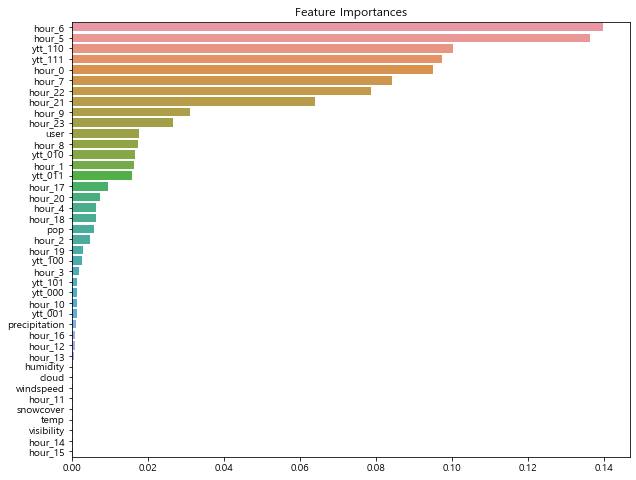

In [462]:
ftr_importances_values = xgb_rg.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train2.columns).sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title('Feature Importances')
sns.barplot(x=ftr_importances, y=ftr_importances.index)
plt.show()

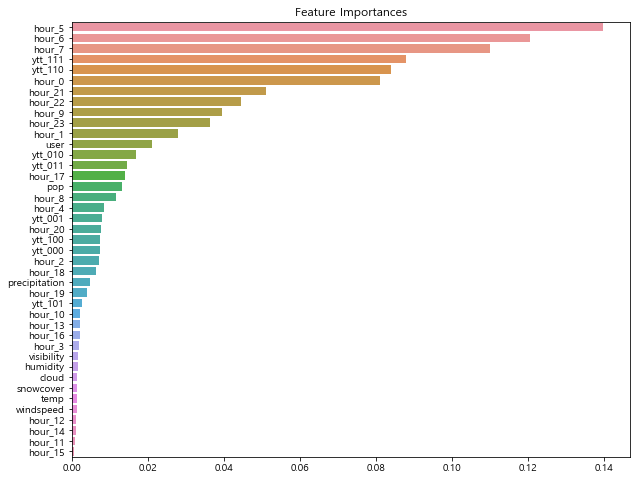

In [463]:
ftr_importances_values = final_xgb_model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train2.columns).sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title('Feature Importances')
sns.barplot(x=ftr_importances, y=ftr_importances.index)
plt.show()

### 튜닝된 모델로 전체데이터 예측

In [464]:
total_data3 = data2.drop('count',axis=1,inplace=False)
total_data3

,temp,windspeed,humidity,cloud,precipitation,snowcover,visibility,user,pop,hour_0,...,hour_22,hour_23,ytt_000,ytt_001,ytt_010,ytt_011,ytt_100,ytt_101,ytt_110,ytt_111
0,14.1,2.6,55,0.0,0.0,0.0,2000,1.0,299.31,1,...,0,0,0,0,0,0,1,0,0,0
1,13.9,2.0,57,2.0,0.0,0.0,2000,1.0,196.59,0,...,0,0,0,0,0,0,1,0,0,0
2,13.9,2.4,56,4.0,0.0,0.0,2000,1.0,173.37,0,...,0,0,0,0,0,0,1,0,0,0
3,13.6,1.6,56,8.0,0.0,0.0,2000,1.0,131.52,0,...,0,0,0,0,0,0,1,0,0,0
4,13.7,1.9,56,10.0,0.0,0.0,2000,1.0,254.17,0,...,0,0,0,0,0,0,1,0,0,0
5,13.7,1.8,57,8.0,0.0,0.0,1999,1.0,1430.63,0,...,0,0,0,0,0,0,1,0,0,0
6,13.3,2.3,56,7.0,0.0,0.0,2000,1.0,4227.82,0,...,0,0,0,0,0,0,1,0,0,0
7,13.1,2.1,58,3.0,0.0,0.0,1997,1.0,12881.29,0,...,0,0,0,0,0,0,1,0,0,0
8,13.7,2.4,54,7.0,0.0,0.0,1960,1.0,15716.97,0,...,0,0,0,0,0,0,1,0,0,0
9,14.9,3.4,50,1.0,0.0,0.0,1989,1.0,8038.56,0,...,0,0,0,0,0,0,1,0,0,0


In [538]:
c = final_xgb_model.predict(total_data3)
taxi['pred3'] = c

In [539]:
evaluate_regr(taxi['count'],c)

MAE : 5.930, MSE : 89.362, RMSE : 9.453, RMSLE : 0.157


#### 전체기간

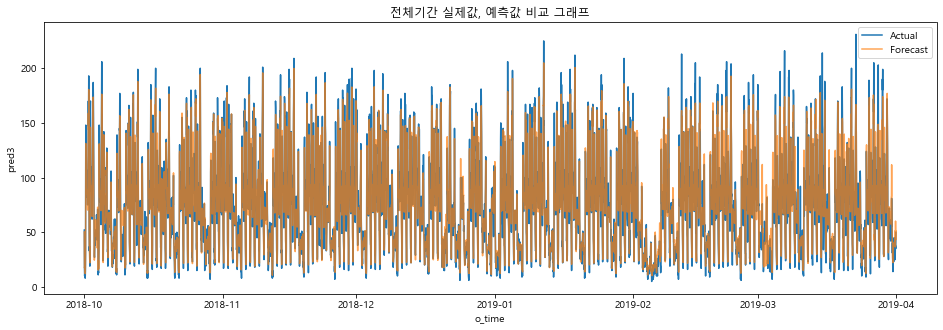

In [497]:
plt.figure(figsize=(16,5))
plt.title('전체기간 실제값, 예측값 비교 그래프')
sns.lineplot(x=taxi.index,y='count',data=taxi)
sns.lineplot(x=taxi.index,y='pred3',data=taxi,alpha=0.7)
plt.legend(['Actual','Forecast'])
plt.show()

#### 한달

In [393]:
taxi.set_index('o_time',inplace=True)

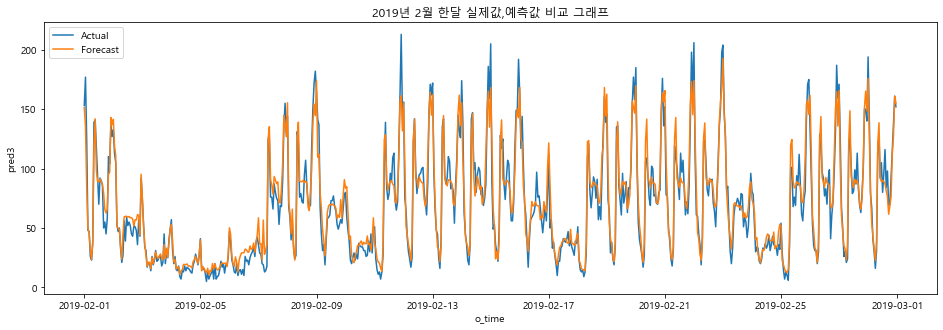

In [498]:
plt.figure(figsize=(16,5))
plt.title('2019년 2월 한달 실제값,예측값 비교 그래프')
sns.lineplot(x=taxi['2019-02'].index,y='count',data=taxi['2019-02'])
sns.lineplot(x=taxi['2019-02'].index,y='pred3',data=taxi['2019-02'])
plt.legend(['Actual','Forecast'])
plt.show()

#### 일주일

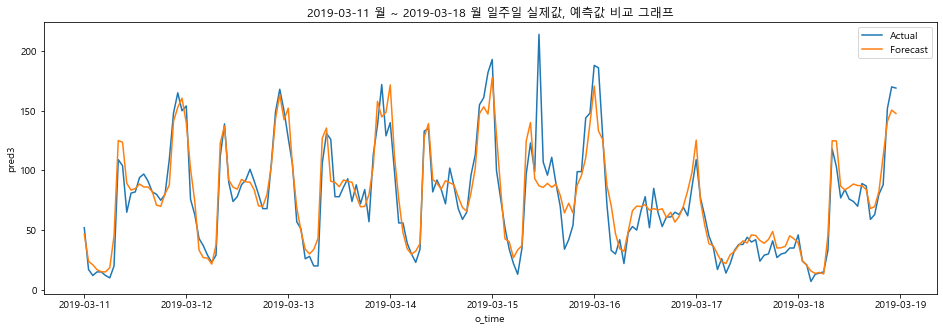

In [521]:
plt.figure(figsize=(16,5))
plt.title('2019-03-11 월 ~ 2019-03-18 월 일주일 실제값, 예측값 비교 그래프')
sns.lineplot(x=taxi['2019-03-11':'2019-03-18'].index,y='count',data=taxi['2019-03-11':'2019-03-18'])
sns.lineplot(x=taxi['2019-03-11':'2019-03-18'].index,y='pred3',data=taxi['2019-03-11':'2019-03-18'])
plt.legend(['Actual','Forecast'])
plt.show()

#### 한글날 ytt 업데이트 x

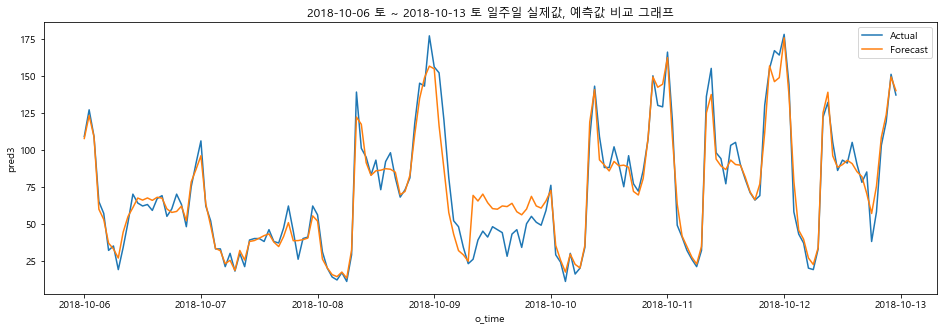

In [500]:
plt.figure(figsize=(16,5))
plt.title('2018-10-06 토 ~ 2018-10-13 토 일주일 실제값, 예측값 비교 그래프')
sns.lineplot(x=taxi['2018-10-06':'2018-10-12'].index,y='count',data=taxi['2018-10-06':'2018-10-12'])
sns.lineplot(x=taxi['2018-10-06':'2018-10-12'].index,y='pred3',data=taxi['2018-10-06':'2018-10-12'])
plt.legend(['Actual','Forecast'])
plt.show()

#### 한글날 ytt 업데이트 o

__한글날 ytt 업데이트 된 데이터셋으로 훈련 후 다시 예측__

__한글날 ytt 업데이트 된 데이터로 훈련데이터셋 생성__

In [501]:
total_data4 = data4.drop('count',axis=1,inplace=False)
total_data4.head()

,temp,windspeed,humidity,cloud,precipitation,snowcover,visibility,user,pop,hour_0,...,hour_22,hour_23,ytt_000,ytt_001,ytt_010,ytt_011,ytt_100,ytt_101,ytt_110,ytt_111
0,14.1,2.6,55,0.0,0.0,0.0,2000,1.0,299.31,1,...,0,0,0,0,0,0,1,0,0,0
1,13.9,2.0,57,2.0,0.0,0.0,2000,1.0,196.59,0,...,0,0,0,0,0,0,1,0,0,0
2,13.9,2.4,56,4.0,0.0,0.0,2000,1.0,173.37,0,...,0,0,0,0,0,0,1,0,0,0
3,13.6,1.6,56,8.0,0.0,0.0,2000,1.0,131.52,0,...,0,0,0,0,0,0,1,0,0,0
4,13.7,1.9,56,10.0,0.0,0.0,2000,1.0,254.17,0,...,0,0,0,0,0,0,1,0,0,0


__모델을 생성 & 예측하고 예측값 컬럼 추가__

In [527]:
final_xgb_model.fit(X_train4,y_train4)

d = final_xgb_model.predict(total_data4)
taxi['pred4'] = d

[21:02:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


__RMSE 확인__

In [528]:
evaluate_regr(taxi['count'],d)

MAE : 5.846, MSE : 86.811, RMSE : 9.317, RMSLE : 0.160


__시각화__

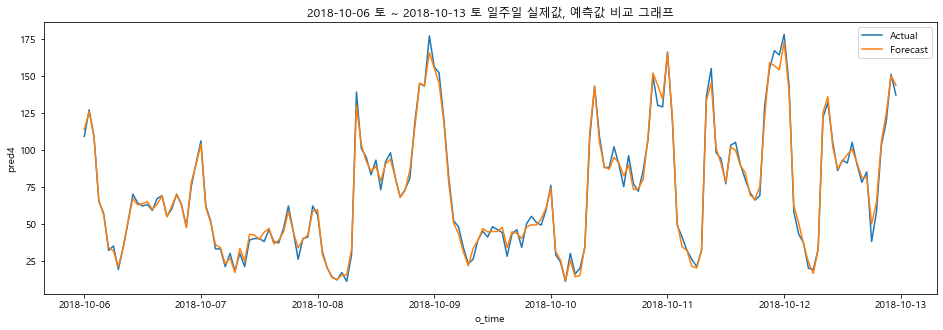

In [529]:
plt.figure(figsize=(16,5))
plt.title('2018-10-06 토 ~ 2018-10-13 토 일주일 실제값, 예측값 비교 그래프')
sns.lineplot(x=taxi['2018-10-06':'2018-10-12'].index,y='count',data=taxi['2018-10-06':'2018-10-12'])
sns.lineplot(x=taxi['2018-10-06':'2018-10-12'].index,y='pred4',data=taxi['2018-10-06':'2018-10-12'])
plt.legend(['Actual','Forecast'])
plt.show()

## 시계열 교차검증 (유동인구 컬럼 X 데이터)  
- 시계열 교차검증은 한글날 ytt 업데이트 된 데이터셋만 검증

### 튜닝 파라미터를 가지고 TimeSeriesSplit 검증

In [842]:
xgb_model = XGBRegressor()
params = {'max_depth':[10],
          'min_child_weight':[4], #   4, 4, 3, 0.9, 500, 0.05, 7 = 22.69
          'gamma':[4],
          'nthread':[3],
          'subsample' : [0.9],
          'n_estimators':[1000],
          'learning_rate': [0.05]}

tscv = TimeSeriesSplit(n_splits=6)
gscv = GridSearchCV(xgb_model, params, cv=tscv, scoring='neg_mean_squared_error')
gscv.fit(X_train3,y_train3)

[11:29:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:30:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:30:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:30:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:30:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:30:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:30:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=6),
       error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [10], 'min_child_weight': [4], 'gamma': [4], 'nthread': [3], 'subsample': [0.9], 'n_estimators': [1000], 'learning_rate': [0.05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [843]:
print('final params : ', gscv.best_params_)
print('best RMSE : ', np.sqrt(np.abs(gscv.best_score_)))

final params :  {'gamma': 4, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 4, 'n_estimators': 1000, 'nthread': 3, 'subsample': 0.9}
best RMSE :  22.913303416612102


### 튜닝된 최적의 파라미터로 모델 생성 및 평가

In [844]:
final_xgb_model = gscv.best_estimator_

final_xgb_model.fit(X_train3,y_train3)
pred = final_xgb_model.predict(X_test3)

evaluate_regr(y_test3,pred)

[11:30:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE : 11.695, MSE : 260.589, RMSE : 16.143, RMSLE : 0.253


### feature 중요도 시각화

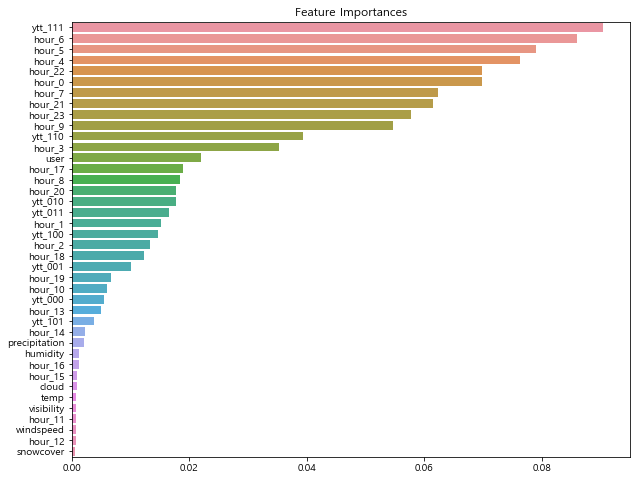

In [750]:
ftr_importances_values = final_xgb_model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train1.columns).sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title('Feature Importances')
sns.barplot(x=ftr_importances, y=ftr_importances.index)
plt.show()

### 튜닝된 모델로 전체데이터 예측

In [676]:
total_data5 = data3.drop('count',axis=1,inplace=False)
total_data5

,temp,windspeed,humidity,cloud,precipitation,snowcover,visibility,user,hour_0,hour_1,...,hour_22,hour_23,ytt_000,ytt_001,ytt_010,ytt_011,ytt_100,ytt_101,ytt_110,ytt_111
0,14.1,2.6,55,0.0,0.0,0.0,2000,1.0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,13.9,2.0,57,2.0,0.0,0.0,2000,1.0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,13.9,2.4,56,4.0,0.0,0.0,2000,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,13.6,1.6,56,8.0,0.0,0.0,2000,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,13.7,1.9,56,10.0,0.0,0.0,2000,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,13.7,1.8,57,8.0,0.0,0.0,1999,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
6,13.3,2.3,56,7.0,0.0,0.0,2000,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
7,13.1,2.1,58,3.0,0.0,0.0,1997,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
8,13.7,2.4,54,7.0,0.0,0.0,1960,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
9,14.9,3.4,50,1.0,0.0,0.0,1989,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [845]:
e = final_xgb_model.predict(total_data5)
taxi['pred5'] = e
evaluate_regr(taxi['count'],e)

MAE : 3.887, MSE : 76.465, RMSE : 8.744, RMSLE : 0.138


#### 전체기간

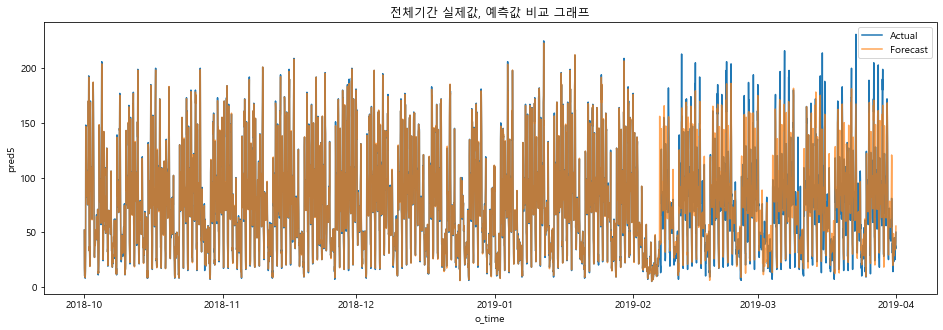

In [805]:
plt.figure(figsize=(16,5))
plt.title('전체기간 실제값, 예측값 비교 그래프')
sns.lineplot(x=taxi.index,y='count',data=taxi)
sns.lineplot(x=taxi.index,y='pred5',data=taxi,alpha=0.7)
plt.legend(['Actual','Forecast'])
plt.show()

#### 한달

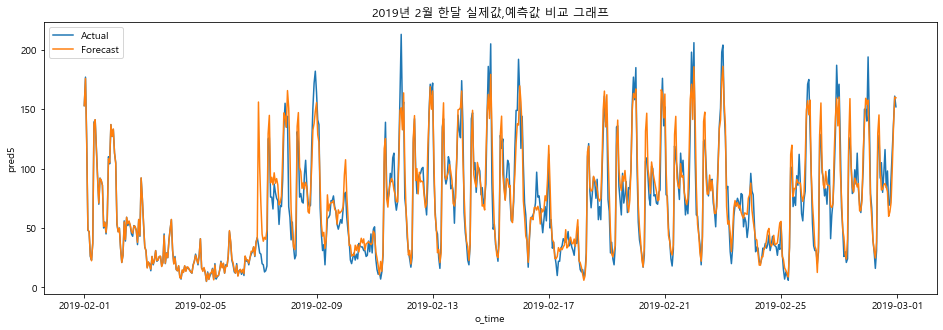

In [814]:
plt.figure(figsize=(16,5))
plt.title('2019년 2월 한달 실제값,예측값 비교 그래프')
sns.lineplot(x=taxi['2019-02'].index,y='count',data=taxi['2019-02'])
sns.lineplot(x=taxi['2019-02'].index,y='pred5',data=taxi['2019-02'])
plt.legend(['Actual','Forecast'])
plt.show()

#### 일주일

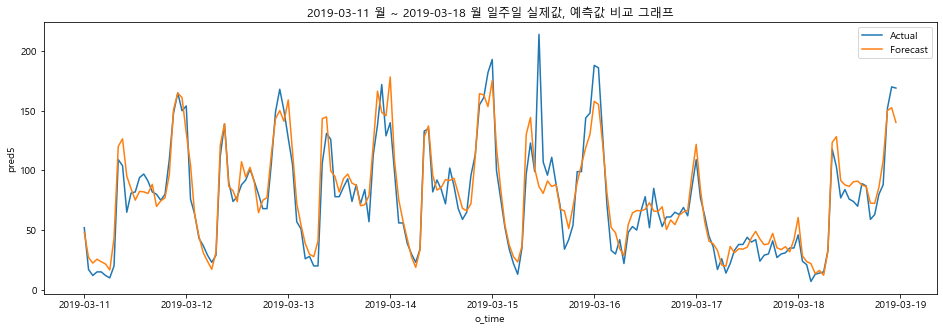

In [818]:
plt.figure(figsize=(16,5))
plt.title('2019-03-11 월 ~ 2019-03-18 월 일주일 실제값, 예측값 비교 그래프')
sns.lineplot(x=taxi['2019-03-11':'2019-03-18'].index,y='count',data=taxi['2019-03-11':'2019-03-18'])
sns.lineplot(x=taxi['2019-03-11':'2019-03-18'].index,y='pred5',data=taxi['2019-03-11':'2019-03-18'])
plt.legend(['Actual','Forecast'])
plt.show()

#### 한글날

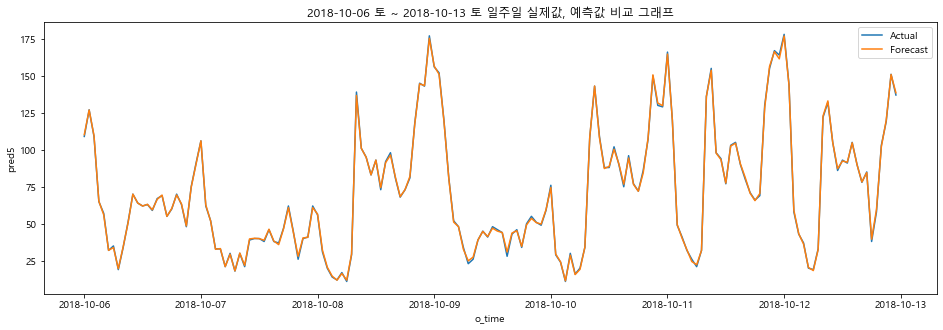

In [823]:
plt.figure(figsize=(16,5))
plt.title('2018-10-06 토 ~ 2018-10-13 토 일주일 실제값, 예측값 비교 그래프')
sns.lineplot(x=taxi['2018-10-06':'2018-10-12'].index,y='count',data=taxi['2018-10-06':'2018-10-12'])
sns.lineplot(x=taxi['2018-10-06':'2018-10-12'].index,y='pred5',data=taxi['2018-10-06':'2018-10-12'])
plt.legend(['Actual','Forecast'])
plt.show()

## 시계열 교차검증 (유동인구 컬럼 O 데이터)  
- 시계열 교차검증은 한글날 ytt 업데이트된 데이터셋만 검증

### 튜닝 파라미터를 가지고 TimeSeriesSplit 검증

In [917]:
xgb_model = XGBRegressor()
params = {'max_depth':[10],     #   10, 3, 2, 2, 0.9, 1000, 0.05, 6 = 21.41
          'min_child_weight':[3], 
          'gamma':[2],
          'nthread':[2],
          'subsample' : [0.9],
          'n_estimators':[1000],
          'learning_rate': [0.05]}

tscv = TimeSeriesSplit(n_splits=7)
gscv = GridSearchCV(xgb_model, params, cv=tscv, scoring='neg_mean_squared_error')
gscv.fit(X_train4,y_train4)

[11:54:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:54:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:54:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:54:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:54:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:54:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:54:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:55:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=7),
       error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [10], 'min_child_weight': [3], 'gamma': [2], 'nthread': [2], 'subsample': [0.9], 'n_estimators': [1000], 'learning_rate': [0.05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [918]:
print('final params : ', gscv.best_params_)
print('best RMSE : ', np.sqrt(np.abs(gscv.best_score_)))

final params :  {'gamma': 2, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 3, 'n_estimators': 1000, 'nthread': 2, 'subsample': 0.9}
best RMSE :  21.302627187102622


### 튜닝된 최적의 파라미터로 모델 생성 및 평가

In [919]:
final_xgb_model = gscv.best_estimator_

final_xgb_model.fit(X_train4,y_train4)
pred = final_xgb_model.predict(X_test4)

evaluate_regr(y_test4,pred)

[11:55:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE : 11.420, MSE : 242.568, RMSE : 15.575, RMSLE : 0.236


### feature 중요도 시각화

In [ ]:
ftr_importances_values = final_xgb_model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train4.columns).sort_values(ascending=False)

plt.figure(figsize=(11,8))
plt.title('Feature Importances')
sns.barplot(x=ftr_importances, y=ftr_importances.index)
plt.show()

### 튜닝된 모델로 전체데이터 예측

In [828]:
total_data6 = data4.drop('count',axis=1,inplace=False)
total_data6

,temp,windspeed,humidity,cloud,precipitation,snowcover,visibility,user,pop,hour_0,...,hour_22,hour_23,ytt_000,ytt_001,ytt_010,ytt_011,ytt_100,ytt_101,ytt_110,ytt_111
0,14.1,2.6,55,0.0,0.0,0.0,2000,1.0,299.31,1,...,0,0,0,0,0,0,1,0,0,0
1,13.9,2.0,57,2.0,0.0,0.0,2000,1.0,196.59,0,...,0,0,0,0,0,0,1,0,0,0
2,13.9,2.4,56,4.0,0.0,0.0,2000,1.0,173.37,0,...,0,0,0,0,0,0,1,0,0,0
3,13.6,1.6,56,8.0,0.0,0.0,2000,1.0,131.52,0,...,0,0,0,0,0,0,1,0,0,0
4,13.7,1.9,56,10.0,0.0,0.0,2000,1.0,254.17,0,...,0,0,0,0,0,0,1,0,0,0
5,13.7,1.8,57,8.0,0.0,0.0,1999,1.0,1430.63,0,...,0,0,0,0,0,0,1,0,0,0
6,13.3,2.3,56,7.0,0.0,0.0,2000,1.0,4227.82,0,...,0,0,0,0,0,0,1,0,0,0
7,13.1,2.1,58,3.0,0.0,0.0,1997,1.0,12881.29,0,...,0,0,0,0,0,0,1,0,0,0
8,13.7,2.4,54,7.0,0.0,0.0,1960,1.0,15716.97,0,...,0,0,0,0,0,0,1,0,0,0
9,14.9,3.4,50,1.0,0.0,0.0,1989,1.0,8038.56,0,...,0,0,0,0,0,0,1,0,0,0


In [920]:
f = final_xgb_model.predict(total_data6)
taxi['pred6'] = f
evaluate_regr(taxi['count'],f)

MAE : 3.633, MSE : 70.874, RMSE : 8.419, RMSLE : 0.128


#### 전체기간

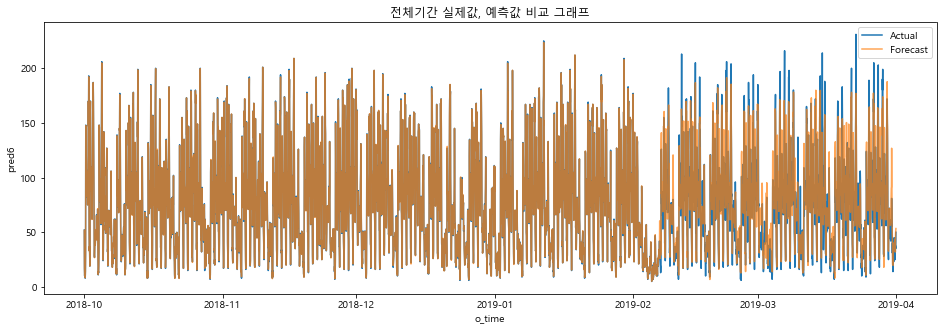

In [922]:
plt.figure(figsize=(16,5))
plt.title('전체기간 실제값, 예측값 비교 그래프')
sns.lineplot(x=taxi.index,y='count',data=taxi)
sns.lineplot(x=taxi.index,y='pred6',data=taxi,alpha=0.7)
plt.legend(['Actual','Forecast'])
plt.show()

#### 한달

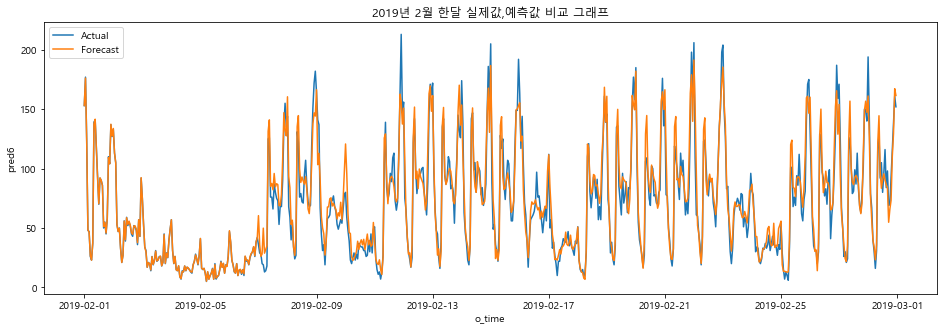

In [923]:
plt.figure(figsize=(16,5))
plt.title('2019년 2월 한달 실제값,예측값 비교 그래프')
sns.lineplot(x=taxi['2019-02'].index,y='count',data=taxi['2019-02'])
sns.lineplot(x=taxi['2019-02'].index,y='pred6',data=taxi['2019-02'])
plt.legend(['Actual','Forecast'])
plt.show()

#### 일주일

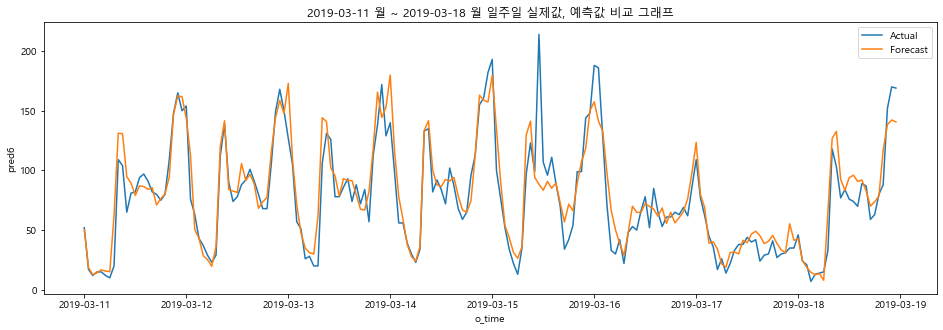

In [937]:
plt.figure(figsize=(16,5))
plt.title('2019-03-11 월 ~ 2019-03-18 월 일주일 실제값, 예측값 비교 그래프')
sns.lineplot(x=taxi['2019-03-11':'2019-03-18'].index,y='count',data=taxi['2019-03-11':'2019-03-18'])
sns.lineplot(x=taxi['2019-03-11':'2019-03-18'].index,y='pred6',data=taxi['2019-03-11':'2019-03-18'])
plt.legend(['Actual','Forecast'])
plt.show()

#### 한글날

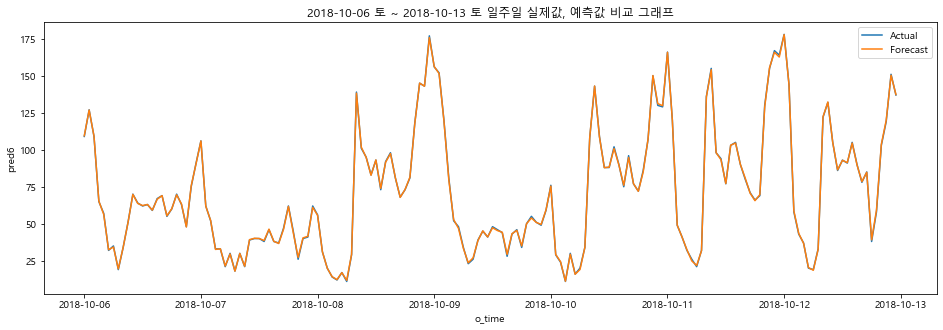

In [931]:
plt.figure(figsize=(16,5))
plt.title('2018-10-06 토 ~ 2018-10-13 토 일주일 실제값, 예측값 비교 그래프')
sns.lineplot(x=taxi['2018-10-06':'2018-10-12'].index,y='count',data=taxi['2018-10-06':'2018-10-12'])
sns.lineplot(x=taxi['2018-10-06':'2018-10-12'].index,y='pred6',data=taxi['2018-10-06':'2018-10-12'])
plt.legend(['Actual','Forecast'])
plt.show()